# Running KRAKEN Ocean Acoustic Model

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tritonoa.core import Top, Bottom, SoundSpeedProfile, Layer, Source, Receiver
from tritonoa.kraken import KRAKENModelConfiguration
from tritonoa.plotting import plot_SSP, plot_TL_2d
from tritonoa.profiles import MunkSSP
from tritonoa.sp import normalize_pressure

## Munk Profile

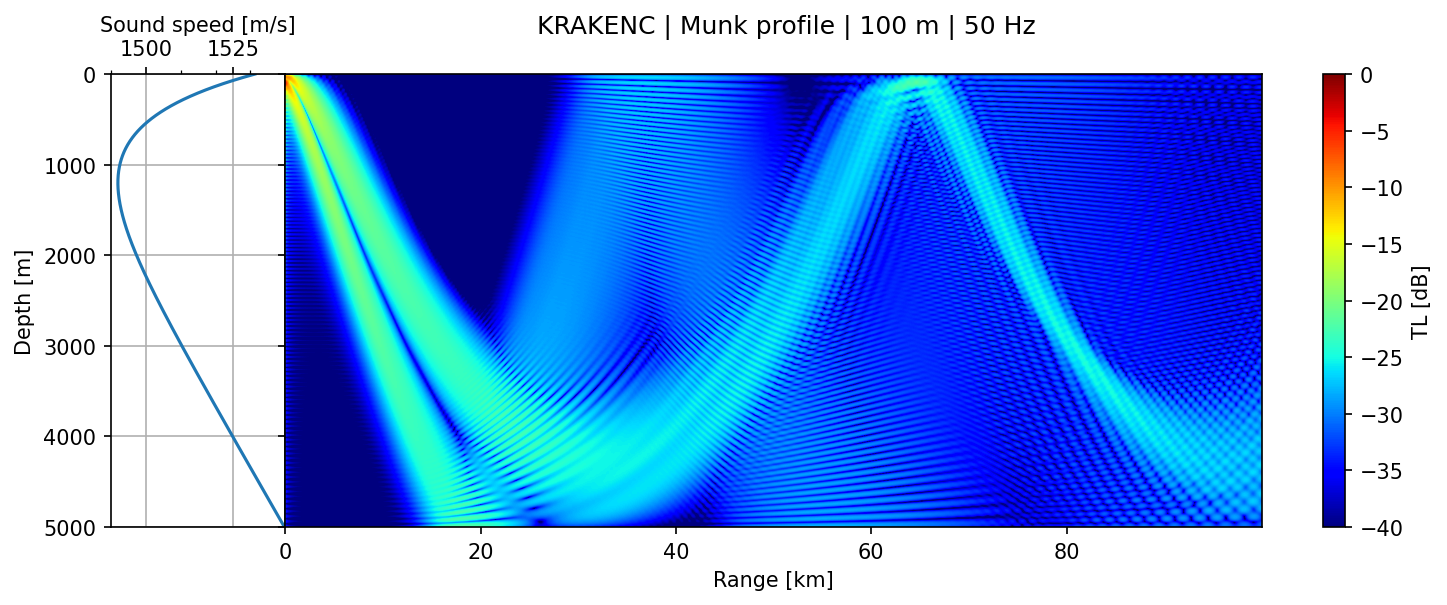

In [17]:
profile = "Munk"
title = profile

top = Top(opt="NVW")

ssp1 = MunkSSP(5000, dz=5)
layer1 = Layer(ssp1)
layers = [layer1]

bottom = Bottom(opt="A", z=layer1.z_max, c_p=1600, rho=1.8, a_p=0.8)

source = Source(100)
zvec = np.arange(0, layer1.z_max+1, 5)
rvec = np.arange(0, 100, 10/1e3)
receiver = Receiver(zvec, rvec)

freq = 50
clow = 1500
chigh = 1600

kmodel = KRAKENModelConfiguration(
    title,
    freq,
    layers,
    top,
    bottom,
    source,
    receiver,
    clow=clow,
    chigh=chigh,
    tmpdir="tmp"
)

model = "KRAKENC"
kmodel.run(fldflag=True, model=model)
p = normalize_pressure(kmodel.modes.p, log=True)

fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={"width_ratios": [1, 7], "wspace": 0}, figsize=(12, 4), dpi=150)

ax = plot_SSP(
    ssp1.z,
    ssp1.c_p,
    xlabel="Sound speed [m/s]",
    ylabel="Depth [m]",
    ax=axs[0]
)
ax = plot_TL_2d(
    p,
    z=kmodel.receiver.z,
    r=np.concatenate((np.array([0]), kmodel.receiver.r)),
    xlabel="Range [km]",
    clabel="TL [dB]",
    vmin=-40,
    ax=axs[1]
)
fig.suptitle(f"{model} | {profile} profile | {kmodel.source.z.item()} m | {freq} Hz")
plt.show()

## SWELLEX

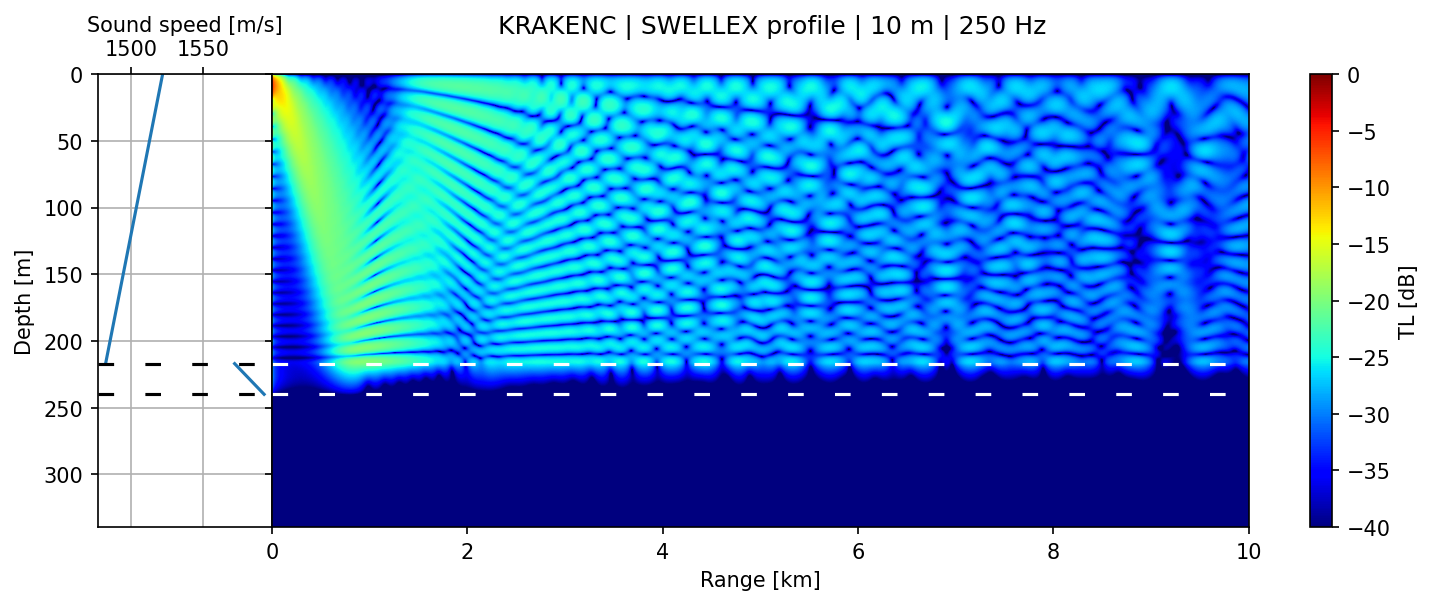

In [18]:
profile = "SWELLEX"
title = profile

top = Top()

ssp1 = SoundSpeedProfile(z=[0, 217], c_p=[1521.95, 1482], rho=1.)
ssp2 = SoundSpeedProfile(z=[217, 240], c_p=[1572.37, 1593.02], rho=1.8, a_p=0.3)
ssp3 = SoundSpeedProfile(z=[240, 1040], c_p=[1881, 3245.8], rho=2.1, a_p=0.09)
layer1 = Layer(ssp1)
layer2 = Layer(ssp2)
layer3 = Layer(ssp3)
layers = [layer1, layer2, layer3]

bottom = Bottom(opt="A", z=layer3.z_max+1, c_p=5200, rho=2.7, a_p=0.03)

source = Source(10)
zvec = np.arange(0, layer2.z_max+100, 0.5)
dr = 0.5e-3
rvec = np.arange(dr, 10+dr, dr)
receiver = Receiver(zvec, rvec)

freq = 250
clow = 0
chigh = 1600

kmodel = KRAKENModelConfiguration(
    title,
    freq,
    layers,
    top,
    bottom,
    source,
    receiver,
    clow=clow,
    chigh=chigh,
    tmpdir="tmp"
)

model = "KRAKENC"
kmodel.run(fldflag=True, model=model)
p = normalize_pressure(kmodel.modes.p, log=True)

fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={"width_ratios": [1, 7], "wspace": 0}, figsize=(12, 4), dpi=150)

z = np.array([])
c = np.array([])
b = np.array([])
for layer in layers[:-1]:
    z = np.concatenate((z, layer.ssp.z))
    c = np.concatenate((c, layer.ssp.c_p))
    b = np.concatenate((b, [layer.z_max]))

ax = plot_SSP(
    z,
    c,
    boundaries=b,
    xlabel="Sound speed [m/s]",
    ylabel="Depth [m]",
    ax=axs[0]
)
ax = plot_TL_2d(
    p,
    z=kmodel.receiver.z,
    r=np.concatenate((np.array([0]), kmodel.receiver.r)),
    boundaries=b,
    xlabel="Range [km]",
    clabel="TL [dB]",
    vmin=-40,
    ax=axs[1]
)
fig.suptitle(f"{model} | {profile} profile | {kmodel.source.z.item()} m | {freq} Hz")
plt.show()

## Arctic Ocean

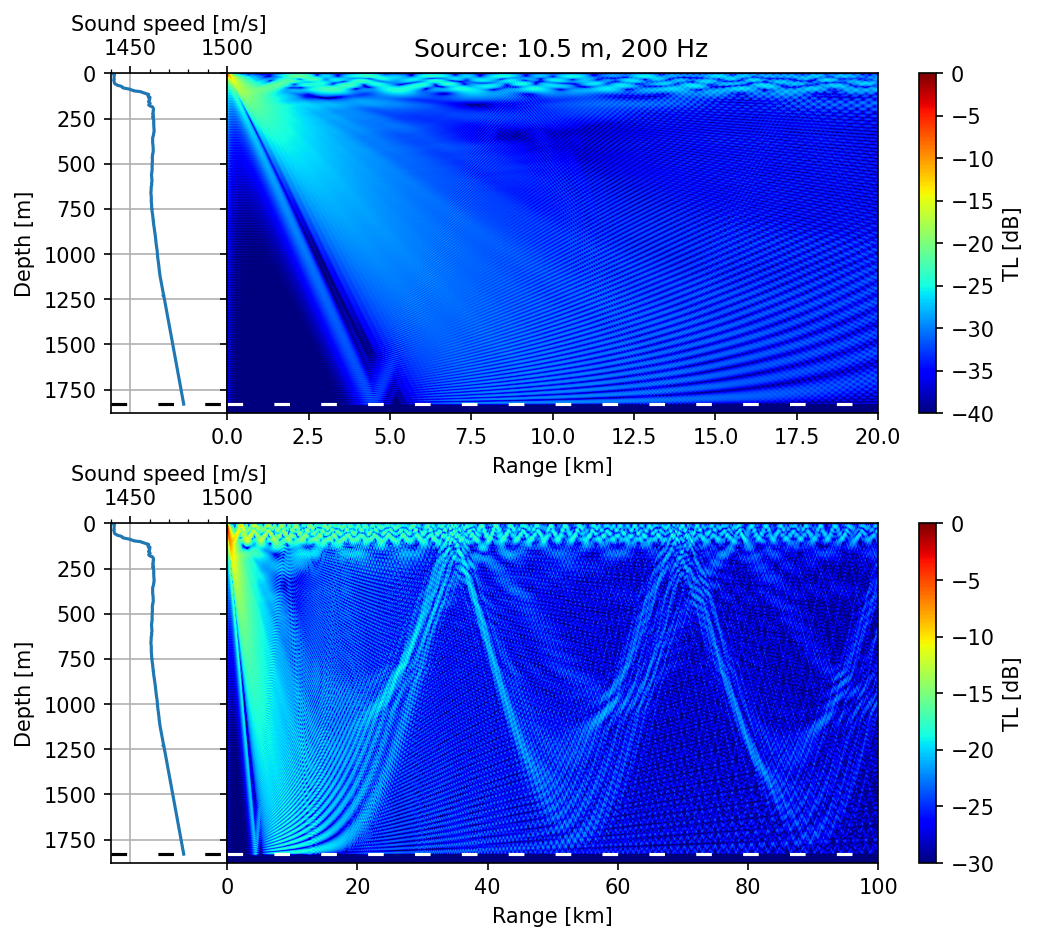

In [36]:
profile = "FramStrait"
title = profile

df = pd.read_csv("XBT.csv")
z_BT = np.array(df.Var1)
cp_BT = np.array(df.Var2)

top = Top(opt="CVW    ")
# Ice properties
z_ice = 2
ssp1 = SoundSpeedProfile(z=[0, z_ice], c_p=3880, c_s=1888, rho=0.920, a_p=0.1656, a_s=0.4835)
layer1 = Layer(ssp1)

# Water properties
mask = z_BT > z_ice
z_BT = z_BT[mask]
cp_BT = cp_BT[mask]
ssp2 = SoundSpeedProfile(z=z_BT, c_p=cp_BT, rho=1.025, a_p=6.5e-5)
layer2 = Layer(ssp2)

# Sediment properties
ssp3 = SoundSpeedProfile(z=[layer2.z_max, layer2.z_max + 50], c_p=1650, rho=1.5, a_p=0.4)
layer3 = Layer(ssp3)

# Bottom properties
layers = [layer1, layer2, layer3]
bottom = Bottom(opt="A", z=layer3.z_max, c_p=4500, rho=2., a_p=0.4)
# layers = [layer1, layer2]
# bottom = Bottom(opt="A", z=layer2.z_max, c_p=4500, rho=2., a_p=0.4)

source = Source(10.5)
zvec = np.arange(0, bottom.z, 1)
dr = 1e-3
rvec = np.arange(dr, 20+dr, dr)
receiver = Receiver(zvec, rvec)

freq = 200
clow = 1400
chigh = 1600

kmodel = KRAKENModelConfiguration(
    title,
    freq,
    layers,
    top,
    bottom,
    source,
    receiver,
    clow=clow,
    chigh=chigh,
    tmpdir="tmp"
)

model = "KRAKENC"
kmodel.run(fldflag=True, model=model)
p = normalize_pressure(kmodel.modes.p, log=True)


fig = plt.figure(figsize=(8, 6), dpi=150)
subfigs = fig.subfigures(2, 1, wspace=0.7)

axsTop = subfigs[0].subplots(1, 2, sharey=True, gridspec_kw={"width_ratios": [1, 7], "wspace": 0})

# fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={"width_ratios": [1, 7], "wspace": 0}, figsize=(8, 3), dpi=150)
ax = plot_SSP(
    layer2.ssp.z,
    layer2.ssp.c_p,
    boundaries=layer2.z_max,
    xlabel="Sound speed [m/s]",
    ylabel="Depth [m]",
    ax=axsTop[0]
)
ax = plot_TL_2d(
    p,
    z=kmodel.receiver.z,
    r=np.concatenate((np.array([0]), kmodel.receiver.r)),
    boundaries=layer2.z_max,
    xlabel="Range [km]",
    clabel="TL [dB]",
    # title=f"{model} | {profile} profile | {kmodel.source.z} m | {freq} Hz",
    vmin=-40,
    ax=axsTop[1],
    cmap="jet"
)


dr = 0.1
rvec = np.arange(dr, 100+dr, dr)
receiver = Receiver(zvec, rvec)

kmodel = KRAKENModelConfiguration(
    title,
    freq,
    layers,
    top,
    bottom,
    source,
    receiver,
    clow=clow,
    chigh=chigh,
    tmpdir="tmp"
)
model = "KRAKENC"
kmodel.run(fldflag=True, model=model)
p = normalize_pressure(kmodel.modes.p, log=True)

axsBot = subfigs[1].subplots(1, 2, sharey=True, gridspec_kw={"width_ratios": [1, 7], "wspace": 0})
ax = plot_SSP(
    layer2.ssp.z,
    layer2.ssp.c_p,
    boundaries=layer2.z_max,
    xlabel="Sound speed [m/s]",
    ylabel="Depth [m]",
    ax=axsBot[0]
)
ax = plot_TL_2d(
    p,
    z=kmodel.receiver.z,
    r=np.concatenate((np.array([0]), kmodel.receiver.r)),
    boundaries=layer2.z_max,
    xlabel="Range [km]",
    clabel="TL [dB]",
    # title=f"{model} | {profile} profile | {kmodel.source.z} m | {freq} Hz",
    vmin=-30,
    ax=axsBot[1],
    cmap="jet"
)
fig.suptitle(f"Source: {kmodel.source.z.item()} m, {freq} Hz")
plt.show()